## Script Engine Performance Test

Three JS engines were compared using [GraalVM](https://www.graalvm.org/) EE: Graal JS, Rhino and Nashorn. These tests were used: [dromaeo](http://dromaeo.com/?dromaeo) 

Before measure perofrmance 20 warm up iterations were executed to allow JIT make some optimizations. 

**System Configuration**:

OS: Ubuntu 18.04<br>

Processor: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz x 4<br>

RAM: 8 GB

Java:<br>

`openjdk version "1.8.0_212"
Java(TM) SE Runtime Environment (build 1.8.0_212-b31)
Java HotSpot(TM) GraalVM EE 19.0.0 (build 25.212-b31-jvmci-19-b01, mixed mode)`

In [1]:
# imports
import json
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
# input params
result_folder = '../../data/graalvm-ee'
warmup_subfolder = '/warmup'
result_subfolder = '/results'

warm_up_count = 20
warm_up_graph_columns = 2

engine_cases = ['nashorn', 'rhino', 'graal-js']

In [3]:
data = {}

def load_test_result(path):
    result = []
    tests = json.load(open(path))
    
    for i, test in enumerate(tests):
        local = {
            'name': test['name'], 
            'samples': 1 / np.array(test['stats']['sample']),
            'speed_error': test['speed'] * test['stats']['rme'] / 100, 
            'speed': test['speed']
        }
        result.append(local)
    return result

    
def load_test_results(engine):
    result = [
        load_test_result(
            result_folder + result_subfolder + 
                '/' + engine + '/results.out'
        )
    ]
    for i in range(0, warm_up_count):
        result.append(
            load_test_result(
                result_folder + warmup_subfolder + '/' + engine + 
                    '/results-iter' + str(i) + '.out'
            )
        )
    data[engine] = result

In [4]:
for engine in engine_cases:
    load_test_results(engine)

In [5]:
%matplotlib inline

def prepare_warm_up_test(testNo):
    res = {
        engine: {
            'speed': [
                iteration[testNo]['speed'] 
                for i, iteration in enumerate(data[engine]) 
                if i > 0
            ],
            'speed_error': [
                iteration[testNo]['speed_error'] 
                for i, iteration in enumerate(data[engine]) 
                if i > 0
            ]
        } for engine in engine_cases
    }
    res['name'] = data['nashorn'][1][testNo]['name']
    return res
    
    
def warm_up_tests_count():
    return len(data['nashorn'][1])


def draw_warm_up_tests():
    columns_number = warm_up_graph_columns
    row_numbers = math.ceil(warm_up_tests_count() / columns_number)
    
    fig, axes = plt.subplots(nrows=row_numbers, ncols=columns_number, figsize=(15, 50))
    plt.subplots_adjust(bottom=0.1, right=0.8)
    plt.suptitle('Warm Up iterations', fontsize=16, y = 0.9)
    
    for row in range(0, row_numbers):
        for col in range(0, columns_number):
            graph_data = prepare_warm_up_test(row * columns_number + col)
            x = np.arange(warm_up_count)
            for engine in engine_cases:
                axes[row, col].errorbar(
                    x, graph_data[engine]['speed'], 
                    graph_data[engine]['speed_error'], 
                    capsize=5, elinewidth=2, 
                    markeredgewidth=2, label=engine, 
                    marker='.'
                )
            axes[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))
            axes[row, col].set_title('Warm up: ' + graph_data['name'])
            axes[row, col].legend()
            axes[row, col].set_ylabel("Speed, op/sec")
            axes[row, col].set_xlabel("Iteration")
            axes[row, col].set_xlim(xmax=warm_up_count)
    plt.show()


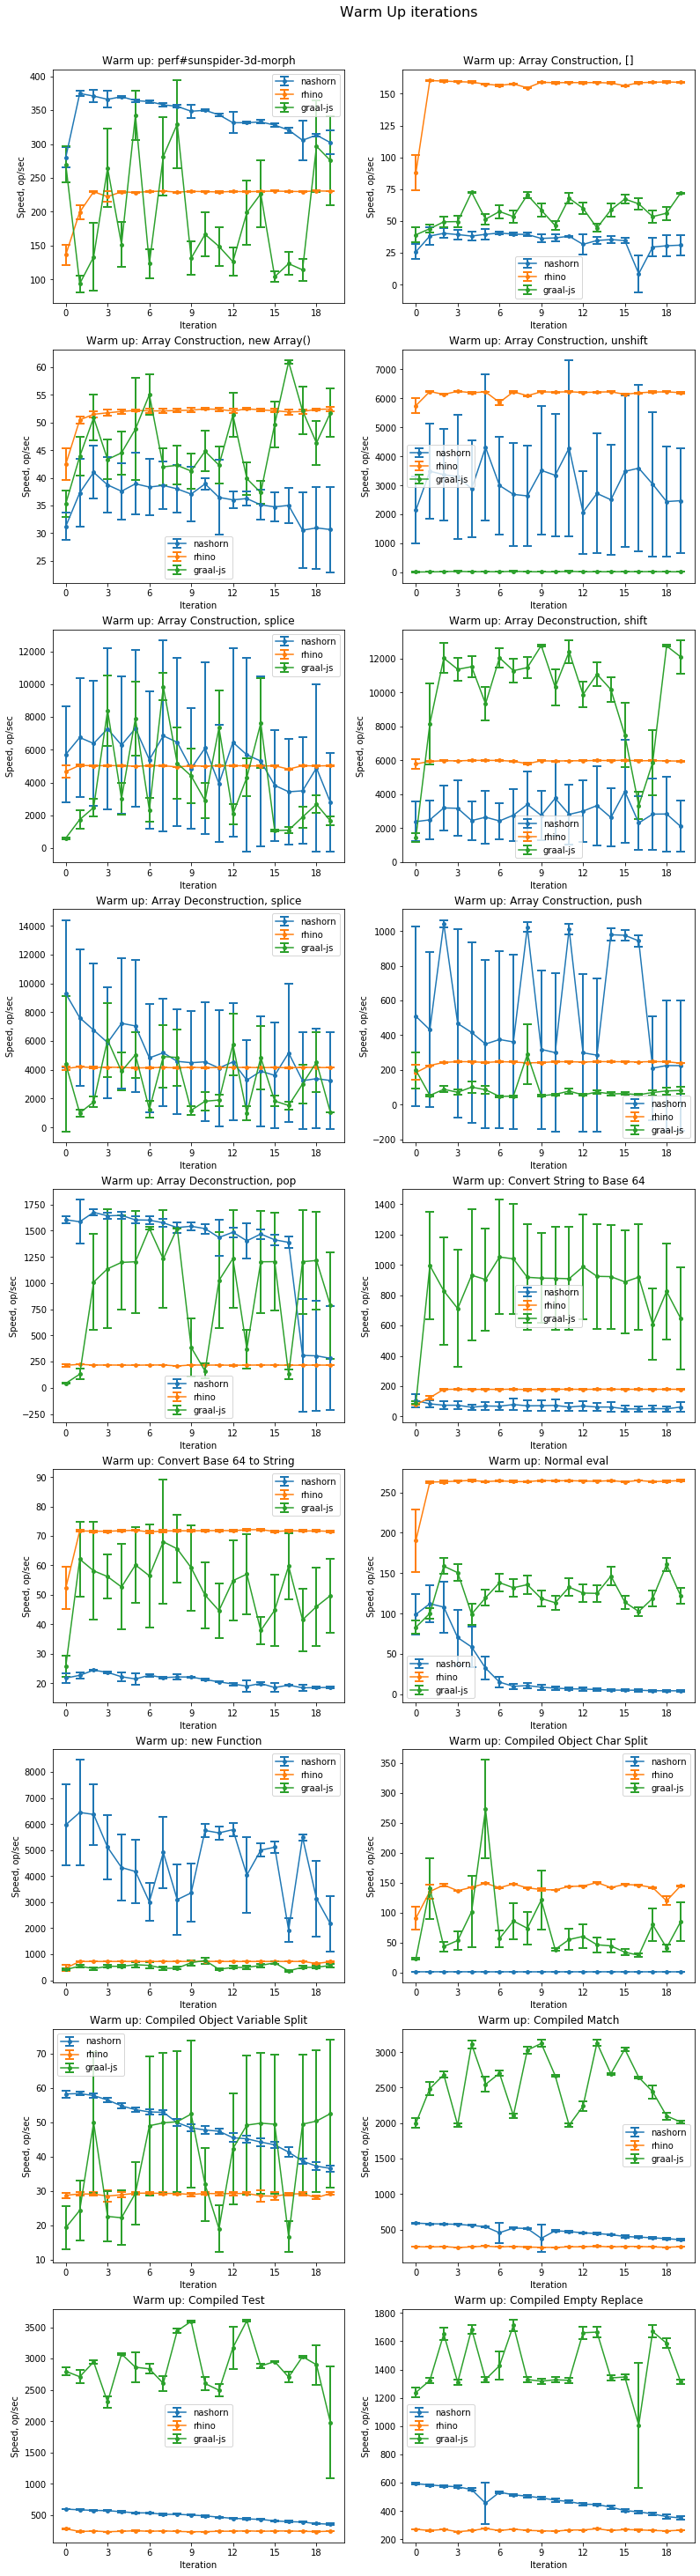

In [6]:
draw_warm_up_tests()

In [7]:
def prepare_final_test():
    result = {
        engine + '_values': [test['speed'] for test in data[engine][0]]
        for engine in engine_cases
    }
    for engine in engine_cases:
        result[engine + '_over_rhino'] = \
            np.array(result[engine + '_values']) / np.array(result['rhino_values']) 
    result['names'] = [test['name'] for test in data['nashorn'][0]]
    return result

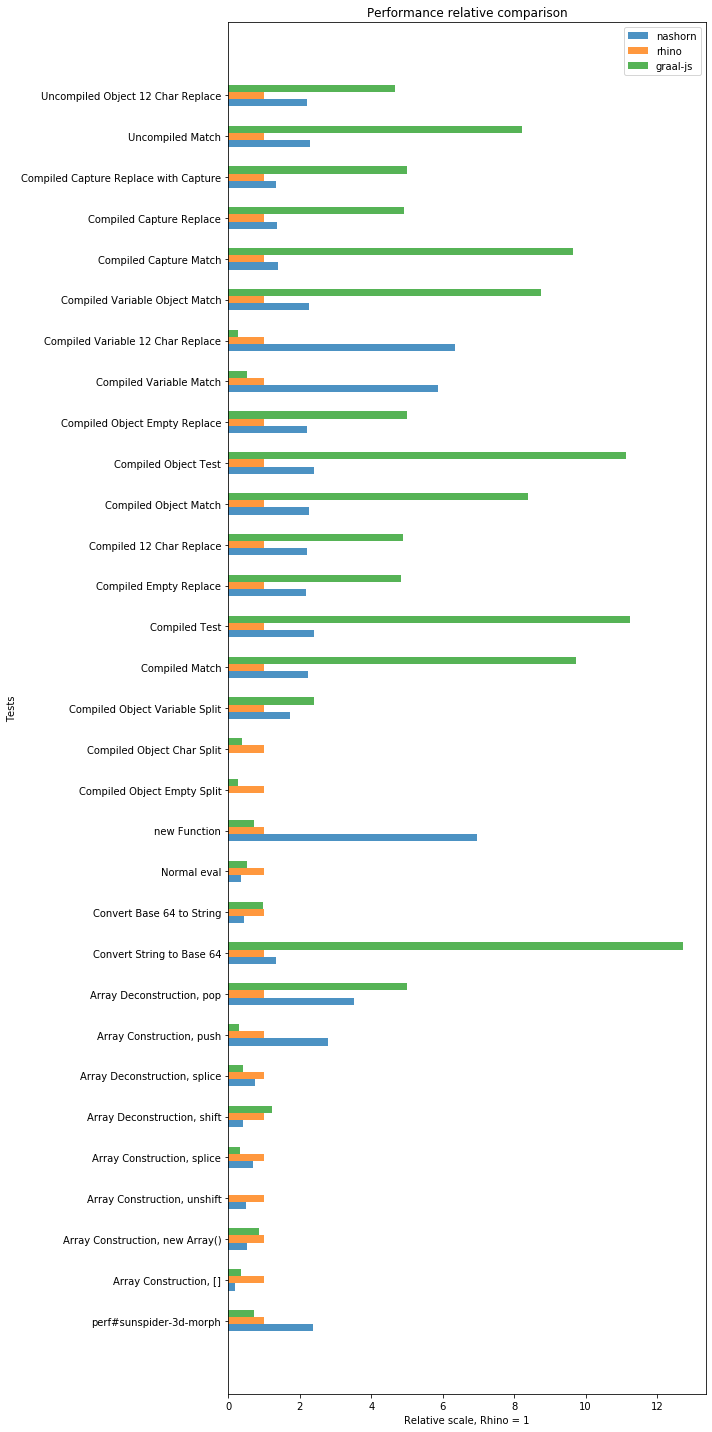

In [8]:
import numpy as np
import matplotlib.pyplot as plt
 
final_test_data = prepare_final_test()  

# data to plot
n_groups = len(final_test_data['names'])
 
# create plot
plt.subplots(figsize=(10, 20))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
for i, engine in enumerate(engine_cases):
    plt.barh(
        2 * index + i * bar_width, 
        final_test_data[engine + '_over_rhino'], 
        bar_width,
        alpha=opacity, label=engine
    )
 
plt.ylabel('Tests')
plt.xlabel('Relative scale, Rhino = 1')
plt.title('Performance relative comparison')
plt.yticks(2 * index + bar_width, final_test_data['names'])
plt.legend()

plt.tight_layout()
plt.show()